In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../CausalModel')

In [3]:
import networkx as nx
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame
import numpy as np
import random
from sklearn.manifold import MDS
from pomegranate.distributions import IndependentComponentsDistribution
from pomegranate.distributions import UniformDistribution, NormalDistribution
%matplotlib inline

In [4]:
import sample_models
from CausalModel.CMD import IDist, ODist, CDist
from cdt.metrics import SID, SHD

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


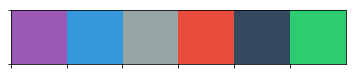

In [5]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
current_palette = sns.color_palette(flatui)
sns.palplot(current_palette)

# Pairwise Comparison of Metrics

### Helpers

In [12]:
default_structure = {
    'nb_nodes': 10,
    'density': 0.3,  # 0.4 / (n ** 1.25 / 10)
    'cycles': False,
    'fraction_observed': 1
}

In [13]:
def generate_causal_models(n):
    pairs = []
    for _ in range(n):
#        model_a, model_b = sample_models.generate_discrete_models(nb_models=2)
#        pairs.append((model_a, model_b))
        model_a, model_b = sample_models.generate_linear_gaussian(default_structure, nb_models=2)
        pairs.append((model_a, model_b))
        model_a, model_b = sample_models.generate_linear_non_gaussian(default_structure, nb_models=2)
        pairs.append((model_a, model_b))
        model_a, model_b = sample_models.generate_GP(default_structure, nb_models=2)
        pairs.append((model_a, model_b))
    return pairs

In [14]:
model_pairs = generate_causal_models(30)

In [15]:
def compare_ODist_SID(pairs, nb_samples):
    X = []
    for model_a, model_b in pairs:
        x_0 = ODist(model_a, model_b, nb_samples, discrete=False)
        x_1 = SID(model_a.causal_graph, model_b.causal_graph)
        X.append([x_0, x_1])
    return DataFrame.from_records(X, columns=['OD', 'SID'])

In [42]:
od_sid = compare_ODist_SID(model_pairs, 1000)

In [31]:
def compare_ODist_SHD(pairs, nb_samples):
    X = []
    for model_a, model_b in pairs:
        x_0 = ODist(model_a, model_b, nb_samples, discrete=False)
        x_1 = SHD(model_a.causal_graph, model_b.causal_graph)
        X.append([x_0, x_1])
    return DataFrame.from_records(X, columns=['OD', 'SHD'])

In [36]:
od_shd = compare_ODist_SHD(model_pairs, 1000)

In [43]:
def compare_IDist_SID(pairs, nb_samples):
    X = []
    for model_a, model_b in pairs:
        x_0 = IDist(model_a, model_b, nb_samples, discrete=False)
        x_1 = SID(model_a.causal_graph, model_b.causal_graph)
        X.append([x_0, x_1])
    return DataFrame.from_records(X, columns=['ID', 'SID'])

In [44]:
id_sid = compare_IDist_SID(model_pairs, 500)

In [45]:
def compare_IDist_SHD(pairs, nb_samples):
    X = []
    for model_a, model_b in pairs:
        x_0 = IDist(model_a, model_b, nb_samples, discrete=False)
        x_1 = SHD(model_a.causal_graph, model_b.causal_graph)
        X.append([x_0, x_1])
    return DataFrame.from_records(X, columns=['ID', 'SHD'])

In [46]:
id_shd = compare_IDist_SHD(model_pairs, 500)

In [137]:
def relplot(data, x, y, fname=None):
    plt.close()
    sns.set_context("notebook")
    ax = sns.relplot(x=x, y=y, data=data, s=100, alpha=0.5)
    plt.grid(False)
    plt.xlabel(x, fontsize=17)
    plt.ylabel(y, fontsize=17)
    if fname:
        plt.savefig(fname, format="pdf")
    plt.show()

### Results

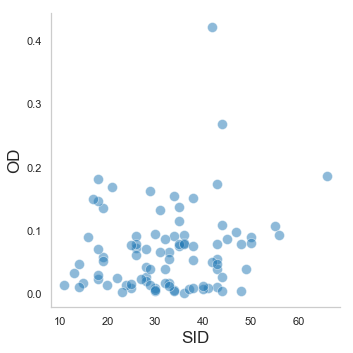

In [135]:
relplot(od_sid, 'SID', 'OD', 'results/sid_od.pdf')

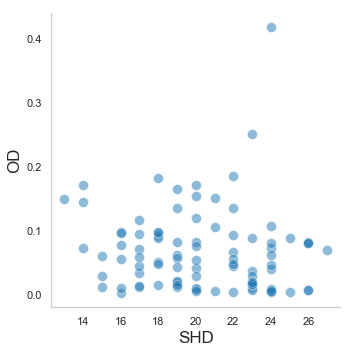

In [138]:
relplot(od_shd, 'SHD', 'OD', 'results/shd_od.pdf')

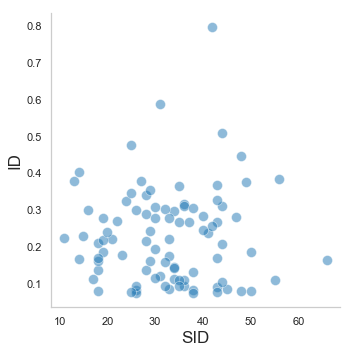

In [139]:
relplot(id_sid, 'SID', 'ID', 'results/sid_id.pdf')

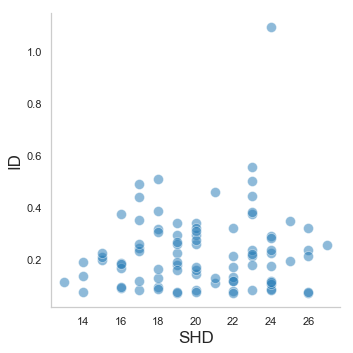

In [140]:
relplot(id_shd, 'SHD', 'ID', 'results/shd_id.pdf')

# Geometry

### Helpers

In [16]:
from CausalModel import Mechanisms, SCM
from CausalModel.Mechanisms import LinearAdditive
from CausalModel.BayesianNetwork import BayesianNetwork

In [17]:
def default_noise(n):
    return IndependentComponentsDistribution([NormalDistribution(0, 0.1) for _ in range(n)])

nodes = [0, 1, 2]
betas = [0.1, 0.5, 1, 2, 5]
noise = default_noise(2)

zero_one = nx.DiGraph([(nodes[0], nodes[1])])
one_zero = nx.DiGraph([(nodes[1], nodes[0])])

for i, node in zero_one.nodes(data=True):
    node['observed'] = True

for i, node in one_zero.nodes(data=True):
    node['observed'] = True

all_scms = {}
for beta in betas:
    ## 0 -> 1+
    causal_struct = copy.deepcopy(zero_one)
    mechanism_end = Mechanisms.LinearAdditive(1)
    mechanism_in = Mechanisms.LinearAdditive(0)
    mechanism_end.coeffs = [beta]
    mechanisms = [mechanism_in, mechanism_end]
    name = '0->1+::' + str(beta)
    all_scms[name] = SCM.SCM(causal_struct, mechanisms, default_noise(2))
    
    ## 0 -> 1-
    causal_struct = copy.deepcopy(zero_one)
    mechanism_end = Mechanisms.LinearAdditive(1)
    mechanism_in = Mechanisms.LinearAdditive(0)
    mechanism_end.coeffs = [-beta]
    mechanisms = [mechanism_in, mechanism_end]
    name = '0->1-::' + str(beta)
    all_scms[name] = SCM.SCM(causal_struct, mechanisms, default_noise(2))
    
    ## 1 -> 0+
    causal_struct = copy.deepcopy(one_zero)    
    mechanism_end = Mechanisms.LinearAdditive(1)
    mechanism_in = Mechanisms.LinearAdditive(0)
    mechanism_end.coeffs = [beta]
    mechanisms = [mechanism_end, mechanism_in]
    name = '1->0+::' + str(beta)
    all_scms[name] = SCM.SCM(causal_struct, mechanisms, default_noise(2))
    
    ## 1 -> 0-
    causal_struct = copy.deepcopy(one_zero)    
    mechanism_end = Mechanisms.LinearAdditive(1)
    mechanism_in = Mechanisms.LinearAdditive(0)
    mechanism_end.coeffs = [-beta]
    mechanisms = [mechanism_end, mechanism_in]
    name = '1->0-::' + str(beta)
    all_scms[name] = SCM.SCM(causal_struct, mechanisms, default_noise(2))

In [18]:
def pairwise_distances_IDist(all_scms):
    pairwise_distance_matrix = np.zeros((len(all_scms), len(all_scms)))
    it = dict(enumerate(all_scms))
    for i in range(len(it)):
        for j in range(i+1,len(it)):
            el_i = all_scms[it[i]]
            el_j = all_scms[it[j]]
            dist = IDist(el_i, el_j, 100, l_samples=15, discrete=False, add_OD=True)
            pairwise_distance_matrix[i][j] = dist
            pairwise_distance_matrix[j][i] = dist
    return pairwise_distance_matrix, it.values()

def pairwise_distances_ODist(all_scms):
    pairwise_distance_matrix = np.zeros((len(all_scms), len(all_scms)))
    it = dict(enumerate(all_scms))
    for i in range(len(it)):
        for j in range(i+1,len(it)):
            el_i = all_scms[it[i]]
            el_j = all_scms[it[j]]
            dist = ODist(el_i, el_j, 1000, discrete=False)
            pairwise_distance_matrix[i][j] = dist
            pairwise_distance_matrix[j][i] = dist
    return pairwise_distance_matrix, it.values()

def pairwise_distances_SID(all_scms):
    pairwise_distance_matrix = np.zeros((len(all_scms), len(all_scms)))
    it = dict(enumerate(all_scms))
    for i in range(len(it)):
        for j in range(i+1,len(it)):
            el_i = all_scms[it[i]]
            el_j = all_scms[it[j]]
            dist = SID(el_i.causal_graph, el_j.causal_graph)
            pairwise_distance_matrix[i][j] = dist
            pairwise_distance_matrix[j][i] = dist
    return pairwise_distance_matrix, it.values()

In [19]:
def convert_label(s):
    if s == "0->1+":
        return "$A \\nearrow  B$"
    if s == "0->1-":
        return "$A \searrow  B$"
    if s == "1->0-":
        return "$B \searrow  A$"
    if s == "1->0+":
        return "$B \\nearrow  A$"

def plot_embedding_3D(pairwise_distance_matrix, labels):
    embedding = MDS(n_components=3, dissimilarity='precomputed')
    data = embedding.fit_transform(pairwise_distance_matrix)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', s=60)
    ax.view_init(30, 295)
    plt.show()
    
def plot_embedding_sns(pairwise_distance_matrix, labels, fname=None):
    embedding = MDS(n_components=2, dissimilarity='precomputed')
    data = embedding.fit_transform(pairwise_distance_matrix)
    
    df = DataFrame({'x': data[:, 0], 'y': data[:, 1]})
    df['Model Type'] = [convert_label(l.split('::')[0]) for l in labels]
    df['Strength ($\\alpha$)'] = [float(l.split('::')[-1]) for l in labels]
    
    sns.set_context("paper")
    plt.close()
    sns.set_style("whitegrid", {'axes.spines.top': True, 'axes.spines.right': True})
#    color_palette = ['#F5793A', '#A95AA1', '#85C0F9', '#0F2080']
#    sns.color_palette()[0:0+4]
    color_palette = sns.color_palette("RdBu", n_colors=7)
    palette = [current_palette[1], current_palette[3], current_palette[4], current_palette[5]]
    g = sns.relplot(x="x", y="y", hue="Model Type", size="Strength ($\\alpha$)", palette=palette, sizes=(30, 700), data=df, legend='full')

    g.set_xlabels('', fontsize=1)
    g.set_ylabels('', fontsize=1)
    
    if fname:
        plt.savefig(fname, format="pdf")    
    plt.show()


### Results

In [25]:
dist_mat_IDist, labels = pairwise_distances_IDist(all_scms)

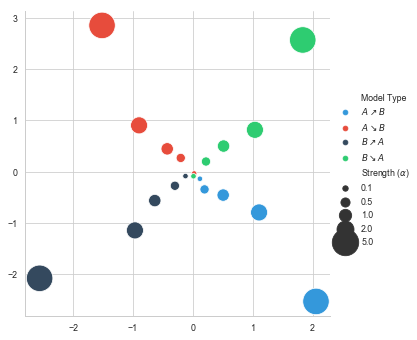

In [112]:
plot_embedding_sns(dist_mat_IDist, labels, fname='results/geometry_id.pdf')

In [80]:
dist_mat_ODist, labels = pairwise_distances_ODist(all_scms)

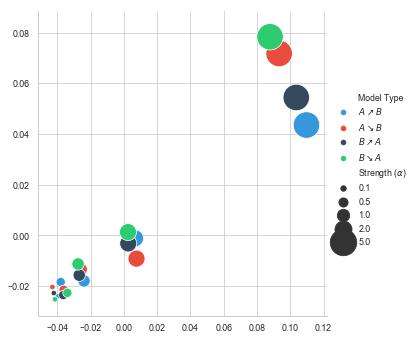

In [114]:
plot_embedding_sns(dist_mat_ODist, labels, fname='results/geometry_od.pdf')

In [90]:
dist_mat_SID, labels = pairwise_distances_SID(all_scms)

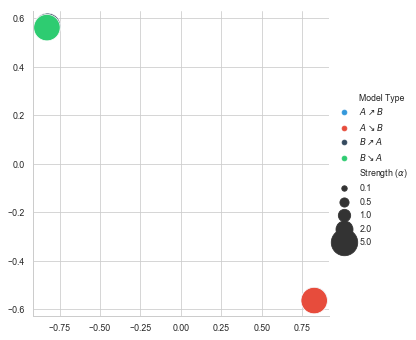

In [115]:
plot_embedding_sns(dist_mat_SID, labels, fname='results/geometry_sid.pdf')

# Sample Efficiency

### NB SAMPLES

In [31]:
default_structure = {
    'nb_nodes': 3,
    'density': 0.3,  # 0.4 / (n ** 1.25 / 10)
    'cycles': False,
    'fraction_observed': 1
}

In [32]:
def OD_sample_efficiency(scm_a, scm_b, K, repetitions):
    data_points = []
    for k in K:
        for _ in range(repetitions):
            d = ODist(scm_a, scm_b, nb_samples=k, discrete=False)
            data_points.append([k, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[k, float(d / max_d)] for k, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['nb_samples', 'ODist'])

def ID_sample_efficiency(scm_a, scm_b, K, repetitions):
    data_points = []
    for k in K:
        for _ in range(repetitions):
            d = IDist(scm_a, scm_b, nb_samples=k, discrete=False)
            data_points.append([k, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[k, float(d / max_d)] for k, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['nb_samples', 'IDist'])

def CD_sample_efficiency(scm_a, scm_b, X, K, repetitions):
    data_points = []
    for k in K:
        for _ in range(repetitions):
            d = CDist(scm_a, scm_b, nb_samples_x=X, nb_samples_k=k, discrete=False)
            data_points.append([k*X, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[k, float(d / max_d)] for k, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['nb_samples', 'CDist'])

In [33]:
scm_a = sample_models.generate_linear_gaussian(nb_models=1)

In [34]:
K = [1, 100, 200, 500]
repetitions = 10

In [39]:
OD_convergence = OD_sample_efficiency(scm_a, scm_a, K, repetitions)

In [41]:
ID_convergence = ID_sample_efficiency(scm_a, scm_a, K, repetitions)

In [37]:
CD_convergence = CD_sample_efficiency(scm_a, scm_a, 1, [1, 100, 200, 500], repetitions=3)

find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25


### Results

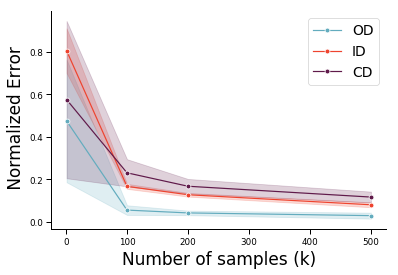

In [42]:
sns.set_context("paper")

ax = sns.lineplot(x='nb_samples', y='ODist', ci="sd", data=OD_convergence, label='OD', marker="o", color="#63ACBE")
sns.lineplot(x='nb_samples', y='IDist', ci="sd", ax=ax, data=ID_convergence, label='ID', marker="o", color="#EE442F")
sns.lineplot(x='nb_samples', y='CDist', ci="sd", data=CD_convergence, ax=ax, label='CD', marker="o", color="#601A4A")
plt.xlabel('Number of samples (k)', fontsize=17)
plt.ylabel(' Normalized Error', fontsize=17)

ax.legend(fontsize='x-large')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("results/sample_efficiency.pdf", bbox_inches='tight', format="pdf")

### k,l,m Sample Efficiency

In [84]:
def k_sample_efficiency(scm_a, scm_b, K, repetitions):
    data_points = []
    for k in K:
        for _ in range(repetitions):
            d = ODist(scm_a, scm_b, nb_samples=k, discrete=False)
            data_points.append([k, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[float(k / max(K)), float(d / max_d)] for k, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['nb_samples', 'ODist'])
    
def l_sample_efficiency(scm_a, scm_b, L, repetitions):
    data_points = []
    for l in L:
        for _ in range(repetitions):
            d = IDist(scm_a, scm_b, nb_samples=500, l_samples=l, discrete=False)
            data_points.append([l, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[float(l / max(L)), float(d / max_d)] for l, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['nb_samples', 'IDist'])

def m_sample_efficiency(scm_a, scm_b, M, repetitions):
    data_points = []
    for m in M:
        for _ in range(repetitions):
            d = CDist(scm_a, scm_b, nb_samples_x=m, discrete=False)
            data_points.append([m, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[float(m / max(M)), float(d / max_d)] for m, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['nb_samples', 'CDist'])

In [77]:
k_convergence = k_sample_efficiency(scm_a, scm_a, [1, 100, 200, 500], repetitions=10)

In [78]:
l_convergence = l_sample_efficiency(scm_a, scm_a, [1, 5, 10, 20], repetitions=10)

In [85]:
m_convergence = m_sample_efficiency(scm_a, scm_a, [1, 2, 4, 8], repetitions=10)

find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.125
find

find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.0625
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.125
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25


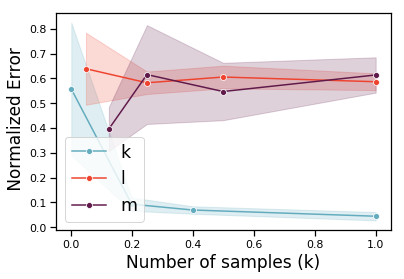

In [86]:
sns.set_context("notebook")

ax = sns.lineplot(x='nb_samples', y='ODist', ci="sd", data=k_convergence, label='k', marker="o", color="#63ACBE")
sns.lineplot(x='nb_samples', y='IDist', ci="sd", ax=ax, data=l_convergence, label='l', marker="o", color="#EE442F")
sns.lineplot(x='nb_samples', y='CDist', ci="sd", data=m_convergence, ax=ax, label='m', marker="o", color="#601A4A")
plt.xlabel('Number of samples (k)', fontsize=17)
plt.ylabel(' Normalized Error', fontsize=17)

ax.legend(fontsize='x-large')

# Sensitivity Analysis

### Helpers

In [6]:
def perturbation(scm, epsilon):
    new_model = copy.deepcopy(scm)
    for m in new_model.mechanisms: 
        m.perturbate(epsilon)
    return new_model

In [7]:
def OD_sensitivity_analysis(scm, perturbations, K, repetitions):
    data_points = []
    for epsilon in perturbations:
        perturbated_scm = perturbation(scm, epsilon)
        for _ in range(repetitions):
            d = ODist(scm, perturbated_scm, nb_samples=K, discrete=False)
            data_points.append([epsilon, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[eps, float(d / max_d)] for eps, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['epsilon', 'ODist'])

def ID_sensitivity_analysis(scm, perturbations, K, repetitions):
    data_points = []
    for epsilon in perturbations:
        perturbated_scm = perturbation(scm, epsilon)
        for _ in range(repetitions):
            d = IDist(scm, perturbated_scm, nb_samples=K, discrete=False)
            data_points.append([epsilon, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[eps, float(d / max_d)] for eps, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['epsilon', 'IDist'])

def CD_sensitivity_analysis(scm, perturbations, X, K, repetitions):
    data_points = []
    for epsilon in perturbations:
        print('{}::{}'.format(epsilon, perturbations))
        perturbated_scm = perturbation(scm, epsilon)
        for i in range(repetitions):
            print('---{}::{}'.format(i, repetitions))
            d = CDist(scm, perturbated_scm, nb_samples_x=X, nb_samples_k=K)
            data_points.append([epsilon, d])
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[eps, float(d / max_d)] for eps, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['epsilon', 'CDist'])

In [8]:
default_structure = {
    'nb_nodes': 4,
    'density': 0.3,  # 0.4 / (n ** 1.25 / 10)
    'cycles': False,
    'fraction_observed': 1
}

In [9]:
scm = sample_models.generate_linear_gaussian(default_structure, nb_models=1)

In [10]:
OD_sensitivity = OD_sensitivity_analysis(scm, [0.01, 0.1, 0.5, 1], 1000, 10)

In [11]:
ID_sensitivity = ID_sensitivity_analysis(scm, [0.01, 0.1, 0.5, 1], 500, 10)

In [12]:
CD_sensitivity = CD_sensitivity_analysis(scm, [0.01, 0.1, 1], X=1, K=500, repetitions=2)

0.01::[0.01, 0.1, 1]
---0::2
x: [0.30901231 0.09249263 0.83007903 0.73802809]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
End IDist
---1::2
x: [0.77920887 0.99117638 0.373939   0.63516711]
Creating noise
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25


invalid value encountered in double_scalars


End noise
Run IDist
End IDist
0.1::[0.01, 0.1, 1]
---0::2
x: [0.00907702 0.94898111 0.00245276 0.48281153]
Creating noise
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 0.25
End noise
Run IDist
End IDist
---1::2
x: [0.44691869 0.79110783 0.6684656  0.69704769]
Creating noise
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 2.0
End noise
Run IDist
End IDist
1::[0.01, 0.1, 1]
---0::2
x: [0.74809465 0.12785666 0.97381141 0.15113836]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
End IDist
---1::2
x: [0.36230968 0.10180741 0.63737261 0.25688543]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
End IDist


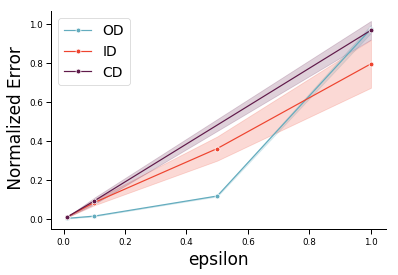

In [26]:
sns.set_context("paper")

ax = sns.lineplot(x='epsilon', y='ODist', ci="sd", data=OD_sensitivity, label='OD', marker="o", color="#63ACBE")
sns.lineplot(x='epsilon', y='IDist', ci="sd", ax=ax, data=ID_sensitivity, label='ID', marker="o", color="#EE442F")
sns.lineplot(x='epsilon', y='CDist', ci="sd", data=CD_sensitivity, ax=ax, label='CD', marker="o", color="#601A4A")
plt.xlabel('epsilon', fontsize=17)
plt.ylabel(' Normalized Error', fontsize=17)

ax.legend(fontsize='x-large')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("results/perturbations.pdf", bbox_inches='tight', format="pdf")

# Specific Perturbations

#### ID with OD constant

In [15]:
from CausalModel.Mechanisms import LinearAdditive
from CausalModel.SCM import SCM

In [16]:
def build_graph(flipped):
    G = nx.DiGraph()
    G.add_node(0, observed=True)
    G.add_node(1, observed=True)
    if flipped:
        G.add_edge(1,0)
    else:
        G.add_edge(0,1)
#    nx.draw_networkx(G)
    return G

def build_mechanisms(beta, flipped):
    A_mechanism = LinearAdditive(nb_causes=0)
    B_mechanism = LinearAdditive(nb_causes=1, generate_random=False)
    B_mechanism.coeffs = [beta]
    if flipped:
        return [B_mechanism, A_mechanism]
    return [A_mechanism, B_mechanism]

def build_noises(mu_a, sigma_a, mu_b, sigma_b):
    return IndependentComponentsDistribution([
        NormalDistribution(mu_a, sigma_a),
        NormalDistribution(mu_b, sigma_b)
    ])

def build_SCM(beta, mu_a, sigma_a, mu_b, sigma_b, flipped=False):
    G = build_graph(flipped)
    mechanisms = build_mechanisms(beta, flipped)
    noises = build_noises(mu_a, sigma_a, mu_b, sigma_b)
    return SCM(G, mechanisms, noises)

In [17]:
def ID_specific_comparison(repetitions):
    a_b = build_SCM(1, 0, 1, 0, 1)
    b_a = build_SCM(1./(np.sqrt(4)), 0, np.sqrt(0.5), 0, np.sqrt(2), flipped=True)
    
    data_points = []
    for _ in range(repetitions):
        data_points.append([0, IDist(a_b, a_b, nb_samples=100, l_samples=5, discrete=False)])
        data_points.append([1, IDist(a_b, b_a, nb_samples=100, l_samples=5, discrete=False)])        
    
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[eps, float(d / max_d)] for eps, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['epsilon', 'IDist'])

In [18]:
id_spec = ID_specific_comparison(10)

#### CD with ID constant

In [19]:
from pomegranate.distributions import GammaDistribution
from sklearn.gaussian_process import GaussianProcessRegressor
import CausalModel.Mechanisms as Mechanisms

In [20]:
def CD_specific_comparison(repetitions):
    nb_training = 1000
    scm_cd = build_SCM(1, 0, 1, 0, 1)
    
    training_samples = scm_cd.sample(nb_training)
    new_graph = copy.deepcopy(scm_cd.causal_graph)
    new_noise = IndependentComponentsDistribution([
        NormalDistribution(0, 1),
        GammaDistribution(alpha=2, beta=2)
    ])
    new_mechanisms = copy.deepcopy(scm_cd.mechanisms)
    

    noise_sample = new_noise.sample(nb_training)
    second_var_noise = noise_sample[:,1]
    cause_values = training_samples[training_samples.columns[0]]

    X = np.column_stack((cause_values.tolist(), second_var_noise)) 
    Y = np.array(training_samples[training_samples.columns[1]].tolist())
    gpr = GaussianProcessRegressor()
    gpr.fit(X, Y)

    new_mechanisms[1] = Mechanisms.GaussianProcess(nb_causes=1, parameters={'nb_points': 10, 'variance': 1})
    new_mechanisms[1].gpr = gpr
    new_SCM = SCM(new_graph, new_mechanisms, new_noise)
    
    data_points = []
    for i in range(repetitions):
        data_points.append([0, CDist(scm_cd, scm_cd, nb_samples_k=100, nb_samples_x=2, discrete=False)])
        data_points.append([1, CDist(scm_cd, new_SCM, nb_samples_k=100, nb_samples_x=2, discrete=False)])        
    
    max_d = max([d_ for _, d_ in data_points])
    updated_data_points = [[eps, float(d / max_d)] for eps, d in data_points]
    return DataFrame.from_records(updated_data_points, columns=['epsilon', 'CDist'])

In [21]:
cd_specific = CD_specific_comparison(5)

x: [0.65459956 0.32418385]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 4.0
End noise
Run IDist
E nd IDist
x: [0.37090114 0.66046202]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0


invalid value encountered in double_scalars


End noise
Run IDist
E nd IDist
x: [0.25886885 0.32901281]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.67117702 0.83306957]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.53389281 0.2248224 ]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.4221152  0.38112136]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 4.0
End noise
Run IDist
E nd IDist
x: [0.55554044 0.10821679]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 2.0


invalid value encountered in double_scalars


End noise
Run IDist
E nd IDist
x: [0.01925184 0.30601409]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 2.0


invalid value encountered in double_scalars


End noise
Run IDist
E nd IDist
x: [0.63222706 0.04505162]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 4.0


invalid value encountered in double_scalars


End noise
Run IDist
E nd IDist
x: [0.55510624 0.87984302]
Creating noise
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.70450723 0.51593739]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.85240414 0.91273334]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.60163444 0.2681533 ]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 4.0
End noise
Run IDist
E nd IDist
x: [0.076154   0.27269032]
Creating noise
find_reasonable_epsilon= 0.25
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.42200943 0.72935846]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0


invalid value encountered in double_scalars


End noise
Run IDist
E nd IDist
x: [0.90686833 0.3737108 ]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.57658857 0.0745203 ]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 4.0
End noise
Run IDist
E nd IDist
x: [0.16537082 0.65367568]
Creating noise
find_reasonable_epsilon= 4.0
find_reasonable_epsilon= 0.25
End noise
Run IDist
E nd IDist
x: [0.25750458 0.92804696]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0
End noise
Run IDist
E nd IDist
x: [0.78259849 0.08681546]
Creating noise
find_reasonable_epsilon= 2.0
find_reasonable_epsilon= 2.0


invalid value encountered in double_scalars


End noise
Run IDist
E nd IDist


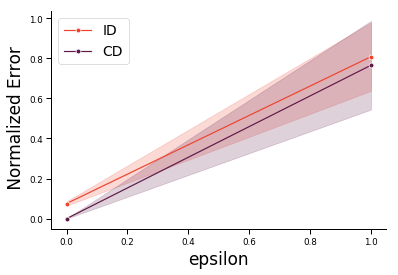

In [25]:
sns.set_context("paper")


ax = sns.lineplot(x='epsilon', y='IDist', ci="sd", data=id_spec, label='ID', marker="o", color="#EE442F")
sns.lineplot(x='epsilon', y='CDist', ci="sd", data=cd_specific, ax=ax, label='CD', marker="o", color="#601A4A")
plt.xlabel('epsilon', fontsize=17)
plt.ylabel(' Normalized Error', fontsize=17)

ax.legend(fontsize='x-large')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("results/specific_perturbations.pdf", bbox_inches='tight', format="pdf")